# 1. Create CLIP Model

Title: Zero Shot Image Classification using the CLIP methodology

Author: [Blaine Perry]

Code inspiration: Keras example 'Natural language image search with a Dual Encoder' (https://keras.io/examples/nlp/nl_image_search/)

Date created: 2021/06/23

Last modified: 2021/06/23

Description: Implementation of a dual encoder model for zero shot learning.

## Introduction
The example demonstrates how to build a dual encoder neural network
model to perform Zero Shot image classification. The model is inspired by
the [CLIP](https://openai.com/blog/clip/) approach, introduced by Alec Radford et al. The idea is to 
train a vision encoder and a text encoder jointly to project the representation of images and their 
captions into the same embedding space, such that the caption embeddings are located near the 
embeddings of the images they describe.

This example requires TensorFlow 2.4 or higher.
In addition, [TensorFlow Hub](https://www.tensorflow.org/hub)
and [TensorFlow Text](https://www.tensorflow.org/tutorials/tensorflow_text/intro)
are required for the BERT model, and [TensorFlow Addons](https://www.tensorflow.org/addons)
is required for the AdamW optimizer. 

## Setup

## Download data and create record files

In [40]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_text
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [1]:
# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

"""
## Prepare the data
We will use the [MS-COCO](https://cocodataset.org/#home) dataset to train our
dual encoder model. MS-COCO contains over 82,000 images, each of which has at least
5 different caption annotations. The dataset is usually used for
[image captioning](https://www.tensorflow.org/tutorials/text/image_captioning)
tasks, but we can repurpose the image-caption pairs to train our dual encoder
model for image search.
###
Download and extract the data
First, let's download the dataset, which consists of two compressed folders:
one with images, and the other—with associated image captions.
Note that the compressed images folder is 13GB in size.
"""

root_dir = "datasets"

annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

NameError: name 'tf' is not defined

In [ ]:
# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath('.'),
        origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
        extract=True,
    )
    os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "train2014.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/zips/train2014.zip",
        extract=True,
    )
    os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

In [3]:
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

NameError: name 'annotation_file' is not defined

In [ ]:
"""
### Process and save the data to TFRecord files
You can change the `sample_size` parameter to control many image-caption pairs
will be used for training the dual encoder model.
In this example we set `train_size` to 30,000 images,
which is about 35% of the dataset. We use 2 captions for each
image, thus producing 60,000 image-caption pairs. The size of the training set
affects the quality of the produced encoders, but more examples would lead to
longer training time.
"""

train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)

In [5]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

In [6]:
#create the tfrecords

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

"""
### Create `tf.data.Dataset` for training and evaluation
"""


feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

NameError: name 'train_image_paths' is not defined

In [7]:
#if the tfrecords are already created, simply pass the counts

train_example_count = 60000
valid_example_count = 10000


feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

60000 training examples were written to tfrecord files.
10000 evaluation examples were written to tfrecord files.


## Train the model

# Start by creating the workspace

In [15]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.31.0


In [17]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: geointerns_workspace
Azure region: usgovarizona
Subscription id: 8dab0d11-5037-44d3-9b24-ed18e6c0845e
Resource group: iso_lrpf


## Create an experiment

In [18]:
from azureml.core import Experiment

script_folder = './keras-CLIP-multi'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-CLIP-multi')

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. Here we wil create `AmlCompute` as your training compute resource.


In [19]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "two-gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC12', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 1, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-08-11T18:57:26.255000+00:00', 'errors': None, 'creationTime': '2021-07-08T18:36:44.988863+00:00', 'modifiedTime': '2021-07-08T18:37:15.441038+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC12'}


## Create an environment

Define a conda environment YAML file with your training script dependencies, which include TensorFlow, Keras and matplotlib, and create an Azure ML environment.

In [20]:
%%writefile conda_dependencies.yml

channels:
- conda-forge
dependencies:
- python=3.8.8
- pip:
  - azureml-defaults
  - matplotlib
  - tqdm
  - tensorflow-gpu==2.5
  - tensorflow_hub
  - tensorflow_text
  - tensorflow_addons

Overwriting conda_dependencies.yml


In [21]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name = 'keras-env', file_path = './conda_dependencies.yml')

# load the string from a file.
keras_env.docker.base_image = None
keras_env.docker.base_dockerfile = "./docker-FRCNN.txt"



## Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

Note that we are specifying a DatasetConsumptionConfig for our FileDataset as an argument to the training script. Azure ML will resolve this DatasetConsumptionConfig to the mount-point of the backing datastore, which we access from the training script.

In [22]:
from azureml.core import Dataset
dataset = Dataset.get_by_name(ws, 'coco')

# list the files referenced by the dataset
dataset.to_path()

['/.amlignore',
 '/.amlignore.amltmp',
 '/train-00.tfrecord',
 '/train-01.tfrecord',
 '/train-02.tfrecord',
 '/train-03.tfrecord',
 '/train-04.tfrecord',
 '/train-05.tfrecord',
 '/train-06.tfrecord',
 '/train-07.tfrecord',
 '/train-08.tfrecord',
 '/train-09.tfrecord',
 '/train-10.tfrecord',
 '/train-11.tfrecord',
 '/train-12.tfrecord',
 '/train-13.tfrecord',
 '/train-14.tfrecord',
 '/valid-00.tfrecord',
 '/valid-01.tfrecord',
 '/valid-02.tfrecord']

In [23]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', dataset.as_named_input('coco').as_mount(),
        '--batch-size', 256,
        '--num-epochs', 30,
        '--num-train-examples', 60000,
        '--num-validation-examples', 10000]

src = ScriptRunConfig(source_directory='.',
                      script='CLIP.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env)

In [24]:
run = exp.submit(src)

# For inference

In [16]:
import tensorflow_text 

In [41]:
import tensorflow_text 
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model(r"C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\outputs\model\vision_encoder")
text_encoder = keras.models.load_model(r"C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\outputs\model\text_encoder")
print("Models are loaded.")

Loading vision and text encoders...
Models are loaded.


In [42]:
fine_labels = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

coarse_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



my_labels = ['rocket', 'kitten', 'dinosaur', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'woman', 'astronaut', 'man', 'doctor']

# Create the text embedding based on the trained text encoder

In [43]:
labels = my_labels

text_descriptions = [f"This is a picture of a {label}" for label in labels]

print(f"Generating embeddings for {len(text_descriptions)} labels...")
text_embeddings = text_encoder.predict(tf.convert_to_tensor(text_descriptions))
#normalize the text embedding
#text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1)

print(f"Image embeddings shape: {text_embeddings.shape}.")

Generating embeddings for 17 labels...
Image embeddings shape: (17, 256).


In [48]:
text_embeddings

array([[ 0.10011403,  0.1330857 ,  0.11665517, ..., -0.06808822,
         0.03385135, -0.03013623],
       [ 0.09198673,  0.18815532,  0.10569839, ..., -0.0732872 ,
        -0.00348067, -0.02802689],
       [ 0.11486056,  0.16374435,  0.13117044, ..., -0.0849896 ,
        -0.01204109, -0.06152457],
       ...,
       [ 0.08404283,  0.16427605,  0.12049535, ..., -0.06089912,
         0.00911857, -0.00127187],
       [ 0.04991973,  0.15796722,  0.11286336, ..., -0.06558248,
         0.04836892, -0.02470594],
       [ 0.06813261,  0.14879847,  0.11379322, ..., -0.05947331,
         0.03802039, -0.00911161]], dtype=float32)

# Create the image embedding

In [45]:
test_image_path = r"C:\Users\blain\Downloads\cat.jpg"

image_array = tf.image.decode_jpeg(tf.io.read_file(test_image_path), channels=3)
image_array = tf.image.resize(image_array, (299, 299))

image_tensor = tf.convert_to_tensor(image_array)

#reshape because the first dimension is batch size
image_tensor = image_tensor[None,:,:,:]

image_embeddings = vision_encoder(image_tensor)

#image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)

print(f"Image embeddings shape: {image_embeddings.shape}.")

Image embeddings shape: (1, 256).


In [46]:
dot_similarity = tf.matmul(100 * text_embeddings, image_embeddings, transpose_b=True)

true_probs = tf.keras.activations.softmax(dot_similarity, axis=0)


results = tf.math.top_k(tf.transpose(dot_similarity), 5).indices.numpy()[0]
probs = tf.math.top_k(tf.transpose(true_probs), 5).values.numpy()[0]

#find the most likely labels
labels = np.array(labels)
top_labels = labels[list(results)]

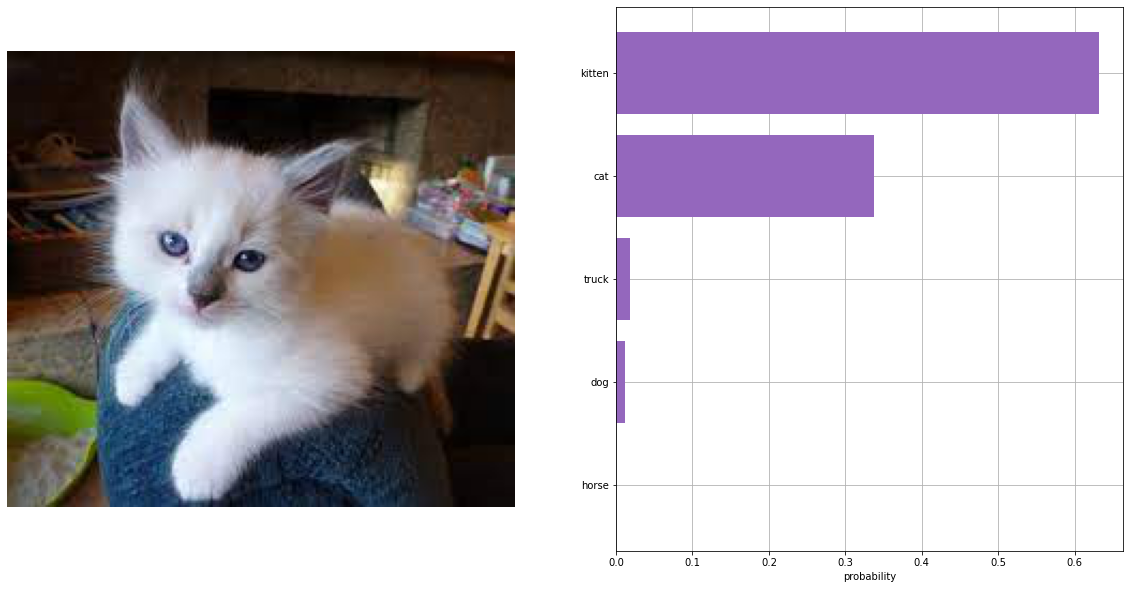

In [47]:
from PIL import Image
image = Image.open(test_image_path).convert("RGB")

#set the image size
plt.figure(figsize=(20, 10))


#show the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")

#show the probabilities
plt.subplot(1, 2, 2)
for i in range(len(probs)):
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in results])
    plt.xlabel("probability")

plt.show()